In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sympy as smp

plt.rcParams.update({"font.size": 14})

In [4]:
cwd = Path.cwd()

z center is at -0.6858762 m

# Load COMSOL Lens Potential

In [5]:
z_center_simulation = -0.6858762

# Load COMSOL Lens Potential

In [6]:
lens_radius = 1.75 * 25.4e-3 / 2
lens_potential = 24e3

In [7]:
potential_data = np.loadtxt(
    cwd / "potential_scatter_larger_cross_section.txt", skiprows=8, delimiter=","
)
potential_xy = potential_data[:, [0, 1, 2, 4]]

In [8]:
potential_xy[:, :3] = np.round(potential_xy[:, :3], 3)

In [9]:
z_center = np.unique(potential_xy[:, 2])[
    np.argmin(abs(np.unique(potential_xy[:, 2]) - -0.6858762))
]
z_center

-0.686

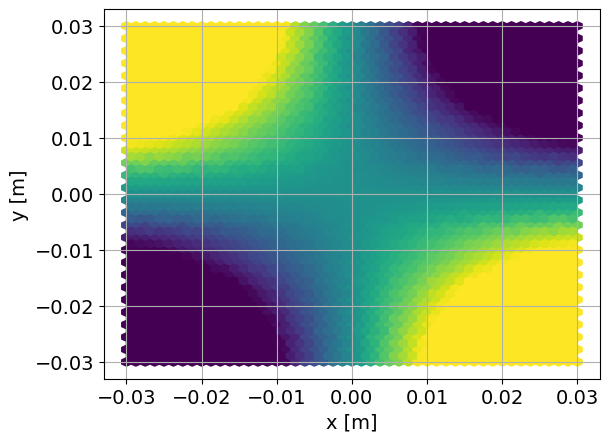

In [ ]:
mask = potential_xy[:, 2] == z_center

x, y, z, v = potential_xy[mask].T

fig, ax = plt.subplots()
ax.hexbin(x, y, v, gridsize=48)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

ax.grid()

In [ ]:
from __future__ import annotations

import numba as nb
import numpy as np
import numpy.typing as npt
from typing import Self


@nb.njit
def fast_scalar_evaluate(x: float, y: float, coeffs: npt.NDArray[np.float64]) -> float:
    result = 0.0
    for i in range(coeffs.shape[0]):
        x_pow = x**i
        for j in range(coeffs.shape[1]):
            result += coeffs[i, j] * x_pow * y**j
    return result


class Polynomial2D:
    """2D polynomial with fitting, evaluation, differentiation, and pretty-printing.

    Attributes:
        kx (int): Maximum exponent in x-direction.
        ky (int): Maximum exponent in y-direction.
        coeffs (np.ndarray): Coefficient matrix of shape (kx+1, ky+1).
        order (int): Optional total-degree cap for the polynomial.
    """

    _subscript_mapping = str.maketrans("0123456789", "₀₁₂₃⁴⁵⁶⁷⁸⁹")
    _superscript_mapping = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

    def __init__(
        self,
        kx: int,
        ky: int,
        coeffs: None | npt.NDArray[np.float64] = None,
        order: None | int = None,
    ) -> None:
        """Initialize a 2D polynomial.

        Args:
            kx (int): Maximum exponent in x-direction.
            ky (int): Maximum exponent in y-direction.
            coeffs (np.ndarray, optional): Coefficient matrix of shape (kx+1, ky+1).
                Defaults to None.
            order (int, optional): Total-degree cap for the polynomial. Defaults to None.
        """
        self.kx = kx
        self.ky = ky
        self.coeffs = coeffs
        self.order = order

    def __call__(
        self, x: npt.NDArray[np.float64], y: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        """Evaluate the polynomial at coordinates (x,y).

        This is a shorthand for the evaluate method.

        Args:
            x (np.ndarray): X coordinates.
            y (np.ndarray): Y coordinates.

        Returns:
            np.ndarray: Evaluated polynomial values.
        """
        return self.evaluate(np.asarray(x), np.asarray(y))

    # ─────────────────────────────── helpers ────────────────────────────────
    @classmethod
    def _str_term_unicode(cls, power: str, arg: str) -> str:
        """Return a Unicode term like ·x² or ·y for pretty printing.

        Args:
            power (str): Power of the term.
            arg (str): Variable name.

        Returns:
            str: Unicode formatted term.
        """
        return (
            f"·{arg}{power.translate(cls._superscript_mapping)}"
            if power != "1"
            else f"·{arg}"
        )

    def _generate_string(self, term_method) -> str:
        """Generate a formatted string of the polynomial terms.

        Args:
            term_method (callable): Function to format term power and variable.
                Should accept (power: str, arg: str) and return formatted string.

        Returns:
            str: Formatted polynomial string with all non-zero terms.

        Notes:
            Handles special cases for zero and constant terms.
            Formats terms with appropriate signs (+ or -).
        """
        out = f"{self.coeffs[0, 0]}" if self.coeffs[0, 0] != 0 else ""

        out = f"{self.coeffs[0, 0]}" if self.coeffs[0, 0] != 0 else ""
        for i, j in np.ndindex((self.kx + 1, self.ky + 1)):
            coef = self.coeffs[i, j]
            if coef == 0 or (i == 0 and j == 0):
                continue

            sign, coef_abs = ("+", coef) if coef >= 0 else ("-", -coef)
            term = f" {sign} {coef_abs}"

            if i:
                term += term_method(str(i), "x")
            if j:
                term += term_method(str(j), "y")

            out += term

        return out.lstrip(" +").lstrip(" -")

    # ───────────────────────────── dunder/magic ─────────────────────────────
    def __repr__(self) -> str:
        """Return string representation of the polynomial.

        Returns:
            str: Unicode formatted representation of the polynomial expression.
        """
        return f"Polynomial2D({self._generate_string(Polynomial2D._str_term_unicode)})"

    def __mul__(self, scalar: float | int) -> Self:
        """Multiply polynomial by a scalar.

        Args:
            scalar (float | int): Value to multiply coefficients by.

        Returns:
            Polynomial2D: New polynomial with scaled coefficients.

        Raises:
            TypeError: If scalar is not a float or int.
            ValueError: If coeffs are not set.
        """
        if not isinstance(scalar, (float, int)):
            raise TypeError(
                f"Can only multiply by scalars, got {type(scalar).__name__}"
            )

        if self.coeffs is None:
            raise ValueError("Cannot multiply: polynomial coefficients not set")

        return Polynomial2D(
            self.kx,
            self.ky,
            self.coeffs * scalar,
            order=self.order,
        )

    def __rmul__(self, scalar: float | int) -> Self:
        """Right multiplication by a scalar.

        Args:
            scalar (float | int): Value to multiply coefficients by.

        Returns:
            Polynomial2D: New polynomial with scaled coefficients.

        See Also:
            __mul__: For detailed behavior.
        """
        return self.__mul__(scalar)

    def __imul__(self, scalar: float | int) -> Self:
        """In-place multiplication by a scalar.

        Args:
            scalar (float | int): Value to multiply coefficients by.

        Returns:
            Polynomial2D: Self with updated coefficients.

        Raises:
            TypeError: If scalar is not a float or int.
            ValueError: If coeffs are not set.
        """
        if not isinstance(scalar, (float, int)):
            raise TypeError(
                f"Can only multiply by scalars, got {type(scalar).__name__}"
            )

        if self.coeffs is None:
            raise ValueError("Cannot multiply: polynomial coefficients not set")

        self.coeffs *= scalar
        return self

    def __truediv__(self, scalar: float | int) -> Self:
        """Divide polynomial by a scalar.

        Args:
            scalar (float | int): Value to divide coefficients by.

        Returns:
            Polynomial2D: New polynomial with scaled coefficients.

        Raises:
            TypeError: If scalar is not a float or int.
            ValueError: If coeffs are not set or scalar is zero.
        """
        if not isinstance(scalar, (float, int)):
            raise TypeError(f"Can only divide by scalars, got {type(scalar).__name__}")

        if scalar == 0:
            raise ValueError("Cannot divide by zero")

        if self.coeffs is None:
            raise ValueError("Cannot divide: polynomial coefficients not set")

        return Polynomial2D(
            self.kx,
            self.ky,
            self.coeffs / scalar,
            order=self.order,
        )

    def __rtruediv__(self, scalar: float | int) -> Self:
        """Not supported - cannot divide a scalar by a polynomial.

        Args:
            scalar (float | int): Scalar value.

        Raises:
            TypeError: Always raised as operation is not meaningful.
        """
        raise TypeError("Cannot divide a scalar by a polynomial")

    def __itruediv__(self, scalar: float | int) -> Self:
        """In-place division by a scalar.

        Args:
            scalar (float | int): Value to divide coefficients by.

        Returns:
            Polynomial2D: Self with updated coefficients.

        Raises:
            TypeError: If scalar is not a float or int.
            ValueError: If coeffs are not set or scalar is zero.
        """
        if not isinstance(scalar, (float, int)):
            raise TypeError(f"Can only divide by scalars, got {type(scalar).__name__}")

        if scalar == 0:
            raise ValueError("Cannot divide by zero")

        if self.coeffs is None:
            raise ValueError("Cannot divide: polynomial coefficients not set")

        self.coeffs /= scalar
        return self

    # ─────────────────────────── public interface ───────────────────────────
    def fit(
        self: Self,
        x: npt.NDArray[np.float64],
        y: npt.NDArray[np.float64],
        z: npt.NDArray[np.float64],
        order: None | int = None,
        zero_terms: list[tuple[int, int]] = [],
    ) -> tuple[
        npt.NDArray[np.float64],
        npt.NDArray[np.float64],
        signedinteger[_32Bit],
        npt.NDArray[np.float64],
    ]:
        """Perform least‐squares fit of z = f(x,y) to a 2‑D polynomial.

        Args:
            x (np.ndarray): X coordinates.
            y (np.ndarray): Y coordinates.
            z (np.ndarray): Data values at (x, y).
            order (int, optional): Total‐degree cap for the polynomial.
                Defaults to self.order.
            zero_terms (list[tuple[int, int]], optional): Coefficient indices to force to zero.
                Defaults to None.

        Returns:
            tuple:
                coeffs (np.ndarray): Solution coefficients (flattened).
                residuals (np.ndarray): Sum of squared residuals.
                rank (int): Effective rank of the Vandermonde matrix.
                singular_values (np.ndarray): Singular values from the fit.
        """
        order = self.order if order is None else order
        zero_terms = [] if zero_terms is None else zero_terms

        vand = np.polynomial.polynomial.polyvander2d(x, y, [self.kx, self.ky])

        for i, j in np.ndindex((self.kx + 1, self.ky + 1)):
            if (order is not None and i + j > order) or (i, j) in zero_terms:
                vand[:, i * (self.ky + 1) + j] = 0.0

        mask = ~np.isnan(z)
        sol = np.linalg.lstsq(vand[mask], z[mask], rcond=None)

        self.coeffs = sol[0].reshape((self.kx + 1, self.ky + 1))
        for i, j in np.ndindex(self.coeffs.shape):
            if (order is not None and i + j > order) or (i, j) in zero_terms:
                self.coeffs[i, j] = 0.0

        return sol  # type: ignore[return-value]  # NumPy stubs: OK

    def derivative(self, axis: str = "x") -> Self:
        """Compute ∂/∂x or ∂/∂y, returning a new Polynomial2D.

        Args:
            axis (str): Axis to differentiate along, 'x' or 'y'. Defaults to 'x'.

        Returns:
            Polynomial2D: The derivative polynomial.

        Raises:
            ValueError: If coeffs are unset or axis is invalid.
        """
        if self.coeffs is None:
            raise ValueError("Cannot differentiate before fitting/setting coeffs.")

        if axis == "x":
            return Polynomial2D(
                self.kx - 1,
                self.ky,
                self.coeffs[1:, :] * (np.arange(1, self.kx + 1)[:, None]),
            )
        if axis == "y":
            return Polynomial2D(
                self.kx,
                self.ky - 1,
                self.coeffs[:, 1:] * (np.arange(1, self.ky + 1)[None, :]),
            )
        raise ValueError(f"Axis must be 'x' or 'y', got {axis!r}.")

    def evaluate(
        self, x: npt.NDArray[np.float64], y: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        return np.polynomial.polynomial.polyval2d(x, y, self.coeffs)

ModuleNotFoundError: No module named 'numba'

In [ ]:
mask_fit = np.sqrt(x**2 + y**2) < lens_radius
v_fit = v.copy()
v_fit[~mask_fit] = np.nan
v_fit

kx, ky = 6, 6
potential = Polynomial2D(kx, ky)
sol = potential.fit(x, y, v_fit, zero_terms=[(0, 0), (1, 0), (0, 1)])

Ex = potential.derivative("x")
Ey = potential.derivative("y")

sol

(array([ 0.00000000e+00,  0.00000000e+00, -4.45937560e+01, -8.85212769e+03,
         2.17243105e+06,  1.20672636e+07, -5.61059167e+09,  0.00000000e+00,
        -9.63640518e+07, -1.09868908e+03, -2.04894399e+08, -2.26679805e+08,
         1.28211161e+13,  4.91746130e+11,  3.73335526e+02, -2.59847960e+05,
         1.19566972e+07,  2.91362495e+09, -1.58890298e+11, -4.80104803e+12,
         3.92122532e+14,  1.18811284e+04, -2.14641548e+08,  3.47511543e+08,
        -4.07652098e+13, -1.64660245e+12, -1.55295462e+14, -6.18962920e+08,
        -4.40019374e+06,  1.13655938e+09,  5.31881589e+10, -7.25449327e+12,
        -1.79102367e+14, -2.73653689e+09, -8.99401487e+09, -4.41018577e+07,
         1.28253515e+13, -3.98370524e+11,  1.55272451e+14, -5.11775020e+08,
        -3.15715701e+06, -1.69880561e+05,  6.68407374e+09, -9.96899471e+11,
        -2.60654775e+13, -2.94073489e+09, -7.00718863e+10, -8.65278778e+05,
        -1.32412014e+07]),
 array([], dtype=float64),
 np.int32(34),
 array([8.04503520e

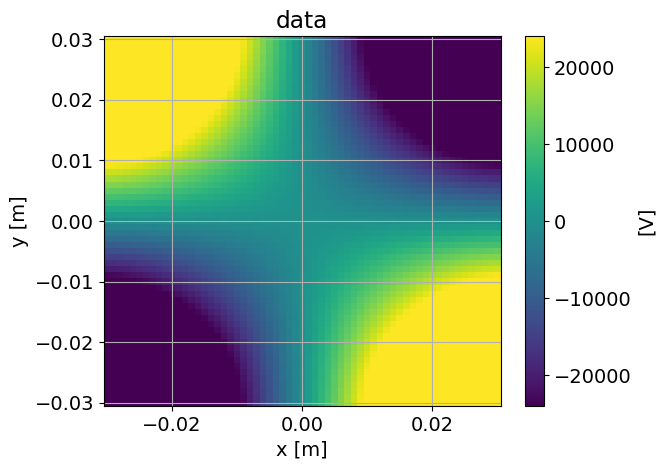

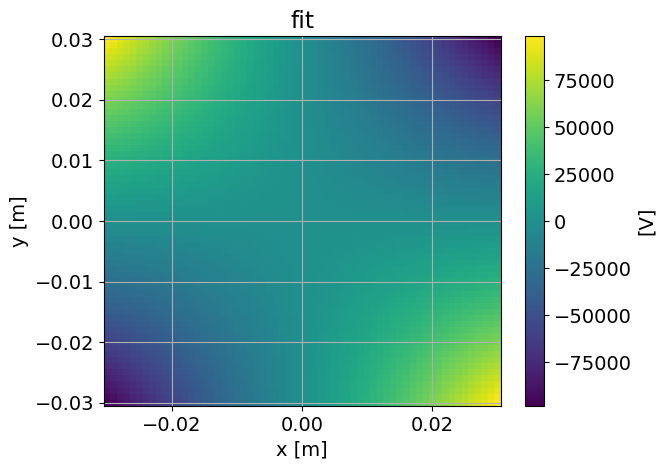

In [ ]:
x_unique = np.unique(x)
y_unique = np.unique(y)

X, Y = np.meshgrid(x_unique, y_unique)
indices = np.lexsort((y, x)).reshape(len(x_unique), len(y_unique))

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, v[indices])
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data")
cbar.ax.set_ylabel("[V]")

ax.grid()

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, potential.evaluate(X, Y))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("fit")
cbar.ax.set_ylabel("[V]")

ax.grid()

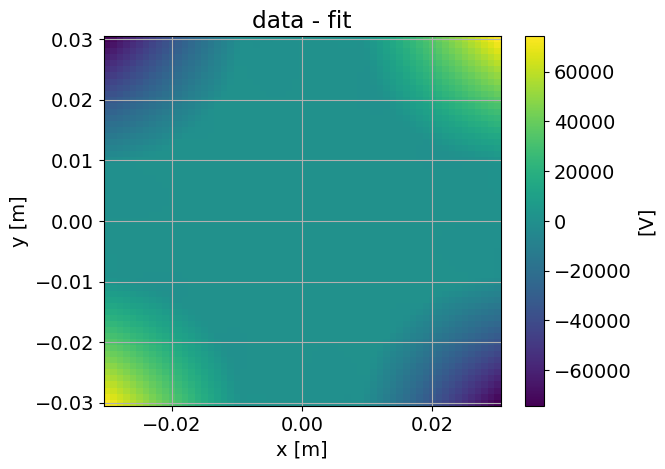

In [ ]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, (v[indices] - potential.evaluate(X, Y)))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data - fit")
cbar.ax.set_ylabel("[V]")

ax.grid()

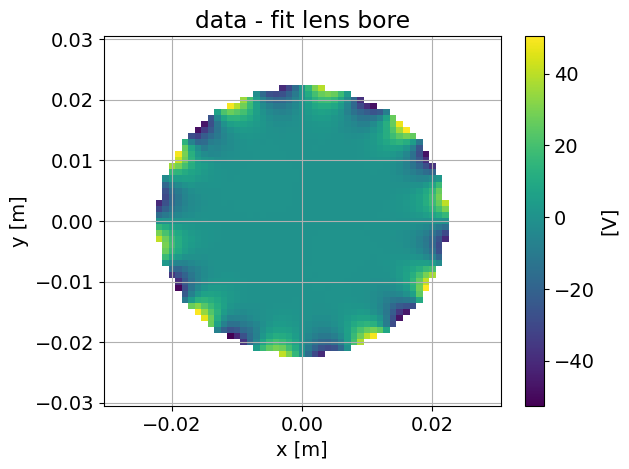

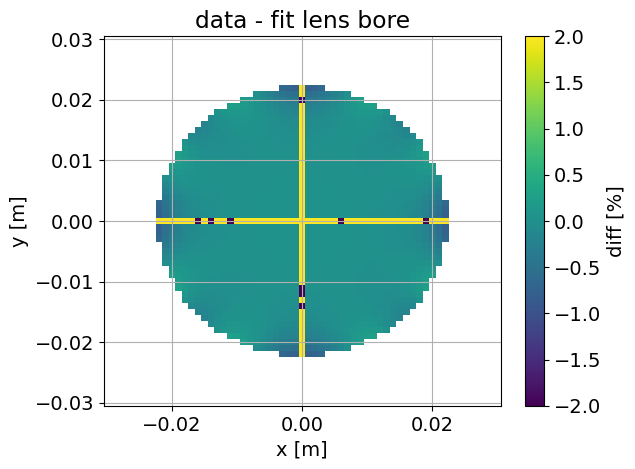

In [ ]:
mask_radius = np.sqrt(X**2 + Y**2) < lens_radius

_z = v[indices] - potential.evaluate(X, Y)
_z[~mask_radius] = np.nan

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, _z)
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data - fit lens bore")
cbar.ax.set_ylabel("[V]")

ax.grid()

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, (_z / v[indices]) * 100, vmin=-2, vmax=2)
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data - fit lens bore")
cbar.ax.set_ylabel("diff [%]")

ax.grid()

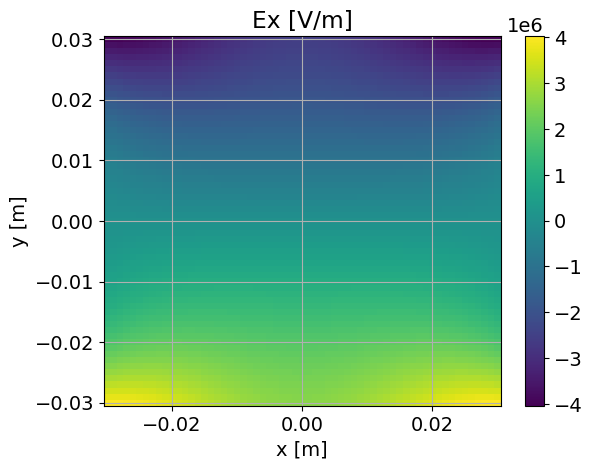

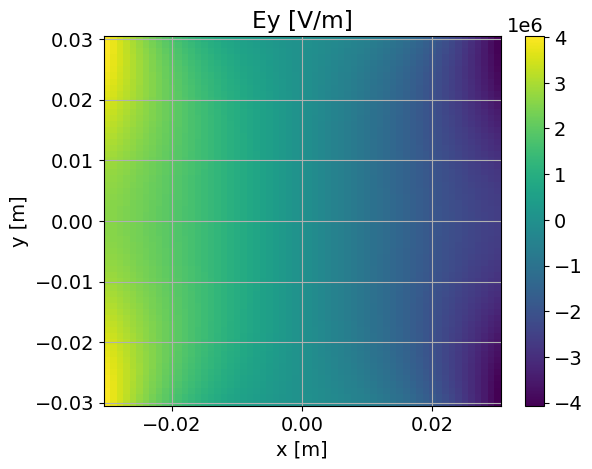

In [ ]:
Ex = potential.derivative("x")

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, Ex.evaluate(X, Y))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Ex [V/m]")

ax.grid()

Ey = potential.derivative("y")

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, Ey.evaluate(X, Y))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Ey [V/m]")

ax.grid()

C:\Users\Olivier\AppData\Local\Temp\ipykernel_1308\1965029416.py:4: RuntimeWarning: invalid value encountered in divide
  _z = (Er_ideal - Er_fit) / Er_ideal * 100


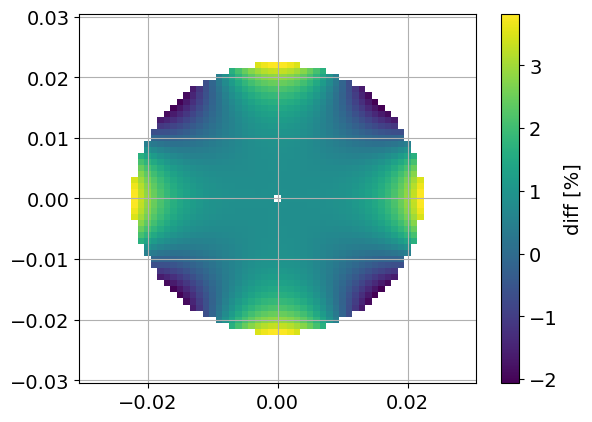

In [ ]:
Er_ideal = 2 * lens_potential * np.sqrt(X**2 + Y**2) / lens_radius**2
Er_fit = np.sqrt(Ex.evaluate(X, Y) ** 2 + Ey.evaluate(X, Y) ** 2)

_z = (Er_ideal - Er_fit) / Er_ideal * 100
_z[~mask_radius] = np.nan

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, _z)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("diff [%]")
ax.grid()

# Setup Beamline
## Parameters

In [ ]:
from centrex_trajectories import (
    Force,
    PropagationOptions,
    PropagationType,
    propagate_trajectories,
    random_generation,
    Gravity,
    Coordinates,
    Velocities,
)
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
)
from centrex_trajectories.particles import TlF

In [19]:
n_trajectories = 3_000_000
options = PropagationOptions(verbose=False, n_cores=8)
particle = TlF()
gravity = Gravity(0, -9.81 * particle.mass, 0)

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 24_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 2

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_width = 8e-3
rc_aperture_height = 6e-3

In [20]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        # RectangularAperture(
        #     x=0,
        #     y=0,
        #     z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
        #     wx=rc_aperture_width,
        #     wy=rc_aperture_height,
        # )
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=0.011,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[
        # CircularAperture(0, 0, bbexit.stop + 19.6 * in_to_m, R * 1.2),
        # CircularAperture(
        #     0,
        #     0,
        #     bbexit.stop + (19.6 + 0.375 + 9.625) * in_to_m,
        #     R * 1.2,
        # ),
    ],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = ElectrostaticQuadrupoleLens(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
)
det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            eql.stop
            + lens_reducer_flange
            + n_nipples * nipple_length
            + distance_det_center
            + 0.001,
            wx,
            wy,
        )
    ],
    start=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center,
    stop=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center
    + 1e-2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)

In [21]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
section_data, trajectories = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)

## Lens with COMSOL Potential

In [22]:
from typing import Any

from centrex_trajectories.common_types import NDArray_or_Float


class ElectrostaticLensPolynomial(ElectrostaticQuadrupoleLens):
    def __init__(
        self,
        name: str,
        objects: list[Any],
        start: float,
        stop: float,
        V: float,
        R: float,
        x: float = 0,
        y: float = 0,
        save_collisions: bool = False,
        stark_potential: None | npt.NDArray[np.float64] = None,
        Ex: Polynomial2D = Ex,
        Ey: Polynomial2D = Ey,
    ) -> None:
        super().__init__(
            name, objects, start, stop, V, R, x, y, save_collisions, stark_potential
        )
        self.Ex = Ex
        self.Ey = Ey

        self._initialize_fields()

    def _initialize_fields(self) -> None:
        self.Ex_x = self.Ex.derivative("x")
        self.Ex_y = self.Ex.derivative("y")
        self.Ey_x = self.Ey.derivative("x")
        self.Ey_y = self.Ey.derivative("y")

    def stark_potential(
        self, x: NDArray_or_Float, y: NDArray_or_Float, z: NDArray_or_Float
    ) -> NDArray_or_Float:
        electric_field = np.linalg.norm(self.electric_field(x, y, z), axis=0)
        return self._stark_potential(electric_field)

    def electric_field(
        self, x: NDArray_or_Float, y: NDArray_or_Float, z: NDArray_or_Float
    ) -> NDArray_or_Float:
        _x = self.x_transformed(x)
        _y = self.y_transformed(y)
        if isinstance(x, np.ndarray):
            return np.asarray(
                [
                    self.Ex.evaluate(_x, _y),
                    self.Ey.evaluate(_x, _y),
                    np.zeros(_x.shape),
                ]
            )
        else:
            return np.asarray([self.Ex.evaluate(_x, _y), self.Ey.evaluate(_x, _y), 0.0])

    def stark_potential_derivative(
        self, x: NDArray_or_Float, y: NDArray_or_Float, z: NDArray_or_Float
    ) -> NDArray_or_Float:
        E = np.linalg.norm(self.electric_field(x, y, z), axis=0)
        return self._stark_potential_derivative(E)

    def force(self, t, x, y, z):
        stark_potential_derivative = self.stark_potential_derivative(x, y, z)
        Ex_x = self.Ex_x.evaluate(x, y)
        Ey_y = self.Ey_y.evaluate(x, y)
        Ex_y = self.Ex_y.evaluate(x, y)
        Ey_x = self.Ey_x.evaluate(x, y)
        Ex, Ey, Ez = self.electric_field(x, y, z)
        electric_field = np.linalg.norm([Ex, Ey, Ez], axis=0)
        electric_field_inverse = np.nan_to_num(1 / electric_field)
        dEx = (Ex * Ex_x + Ey * Ey_x) * electric_field_inverse
        dEy = (Ex * Ex_y + Ey * Ey_y) * electric_field_inverse
        if isinstance(x, np.ndarray):
            return (
                -stark_potential_derivative * dEx,
                -stark_potential_derivative * dEy,
                np.zeros(x.shape),
            )
        else:
            return (
                -stark_potential_derivative * dEx,
                -stark_potential_derivative * dEy,
                0.0,
            )

In [23]:
eql_comsol = ElectrostaticLensPolynomial(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
)
sections_comsol = [fourK, fourtyK, bbexit, rc, spa, eql_comsol, det]
section_data_comsol, trajectories_comsol = propagate_trajectories(
    sections_comsol,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)

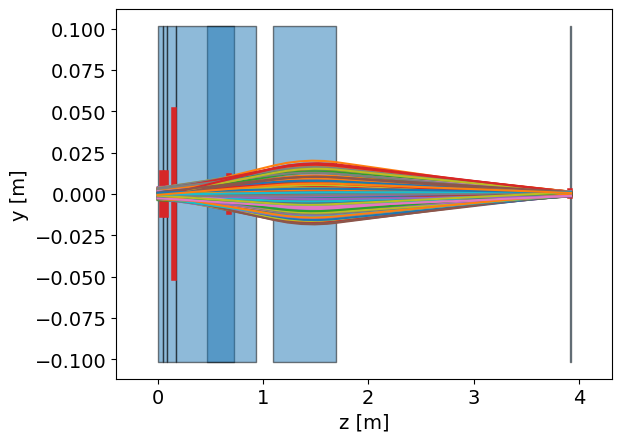

In [24]:
from centrex_trajectories.visualization import plot_beamline


fig, ax = plt.subplots()
plot_beamline(sections_comsol, ax, axis="y")
for traj in trajectories_comsol.values():
    ax.plot(traj.z, traj.y)

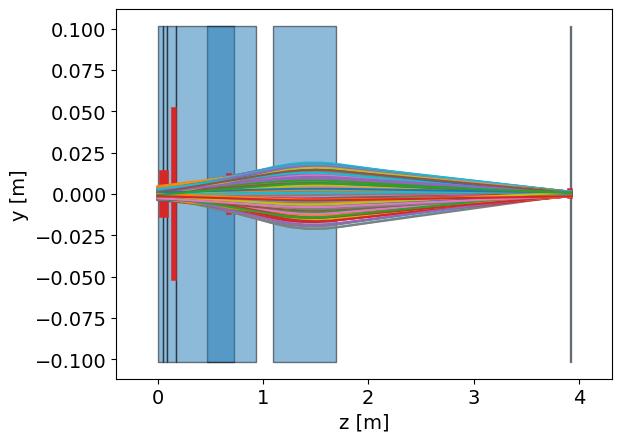

In [25]:
fig, ax = plt.subplots()
plot_beamline(sections, ax, axis="y")
for traj in trajectories.values():
    ax.plot(traj.z, traj.y)

In [26]:
print(
    f"{section_data_comsol[-1].throughput / section_data[-1].throughput * 100:.2f}% w.r.t. quadrupole potential"
)

96.02% w.r.t. quadrupole potential


In [27]:
section_data[-1]

SectionData(name='Detection', saved_collisions=[], nr_collisions=np.int64(7010), nr_trajectories=8014, survived=np.int64(1004), throughput=np.float64(0.12528075867232344))

In [28]:
section_data_comsol[-1]

SectionData(name='Detection', saved_collisions=[], nr_collisions=np.int64(7035), nr_trajectories=7997, survived=np.int64(962), throughput=np.float64(0.12029511066649994))

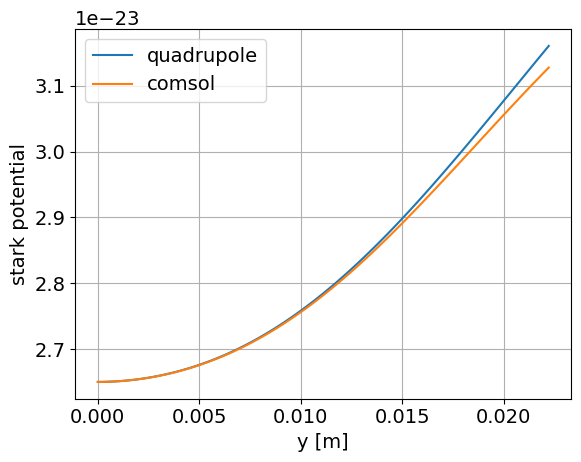

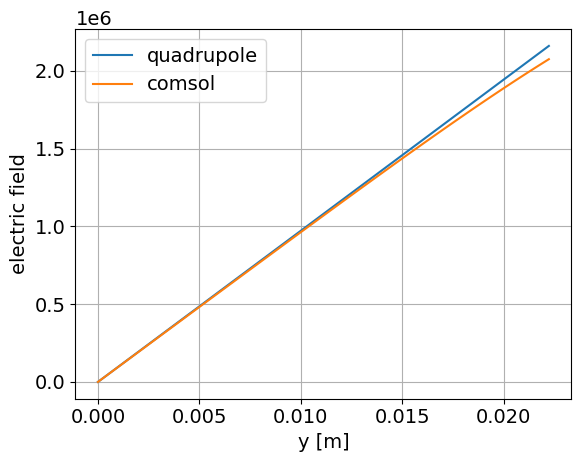

In [29]:
_r = np.linspace(0, R, 101)

fig, ax = plt.subplots()
ax.plot(_r, eql.stark_potential(0, _r, 0), label="quadrupole")
ax.plot(
    _r,
    eql_comsol.stark_potential(np.zeros(_r.shape), _r, np.zeros(_r.shape)),
    label="comsol",
)

ax.set_ylabel("stark potential")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)

fig, ax = plt.subplots()

ax.plot(_r, eql.electric_field(0, _r, 0), label="quadrupole")
ax.plot(
    _r,
    np.linalg.norm(
        eql_comsol.electric_field(np.zeros(_r.shape), _r, np.zeros(_r.shape)), axis=0
    ),
    label="comsol",
)

ax.set_ylabel("electric field")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)

## Test with fit to Quadrupole Potential

In [30]:
V = 24_000
x = X.flatten()
y = Y.flatten()
quadrupole = V * (X**2 - Y**2) / R**2
quadrupole = V * (-2 * X * Y) / R**2

mask_fit = np.sqrt(x**2 + y**2) < lens_radius
q_fit = quadrupole.flatten().copy()
q_fit[~mask_fit] = np.nan


kx, ky = 2, 2
potential_quadrupole = Polynomial2D(kx, ky)
quad_sol = potential_quadrupole.fit(x, y, q_fit, zero_terms=[(0, 0), (1, 0), (0, 1)])

x_unique = np.unique(x)
y_unique = np.unique(y)
indices = np.lexsort((y, x)).reshape(len(x_unique), len(y_unique))

In [31]:
eql_quadrupole = ElectrostaticLensPolynomial(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
    Ex=potential_quadrupole.derivative("x"),
    Ey=potential_quadrupole.derivative("y"),
)

C:\Users\ogras\AppData\Local\Temp\ipykernel_50316\2546268323.py:17: RuntimeWarning: divide by zero encountered in divide
  cax = ax.pcolormesh(X, Y, (q_fit[indices] - _fit[indices]) / q_fit[indices])
C:\Users\ogras\AppData\Local\Temp\ipykernel_50316\2546268323.py:17: RuntimeWarning: invalid value encountered in divide
  cax = ax.pcolormesh(X, Y, (q_fit[indices] - _fit[indices]) / q_fit[indices])


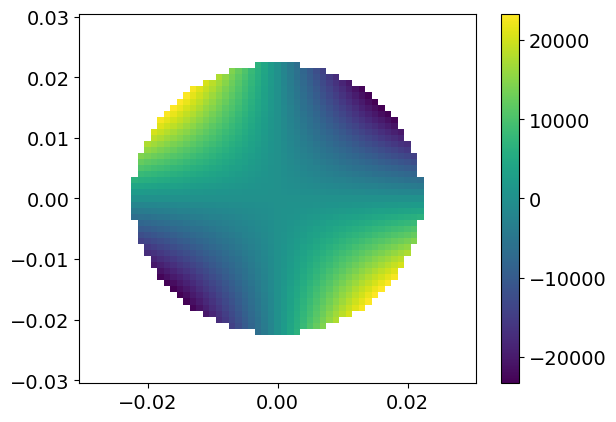

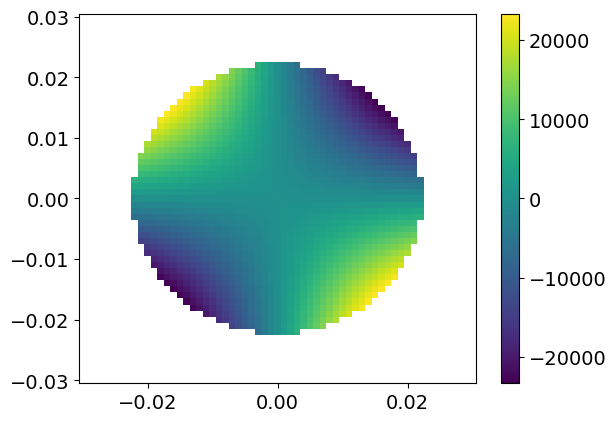

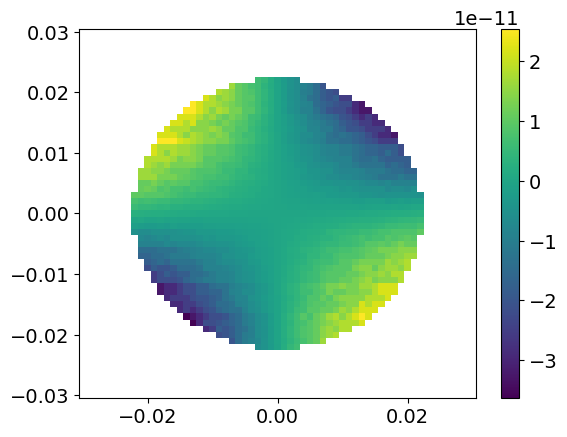

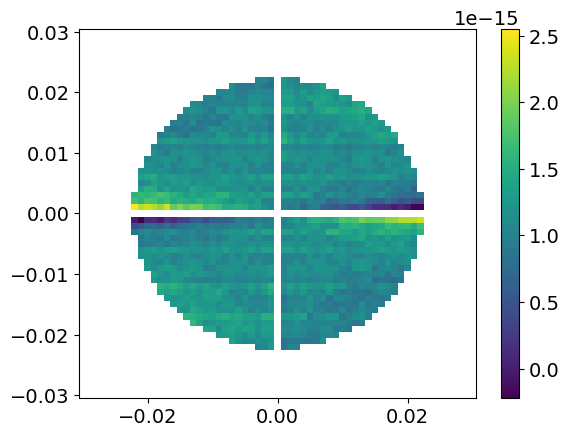

In [32]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, q_fit[indices])
cbar = fig.colorbar(cax)

_fit = potential_quadrupole.evaluate(x, y)
_fit[~mask_fit] = np.nan

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, _fit[indices])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, q_fit[indices] - _fit[indices])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, (q_fit[indices] - _fit[indices]) / q_fit[indices])
cbar = fig.colorbar(cax)

C:\Users\ogras\AppData\Local\Temp\ipykernel_50316\3089133271.py:72: RuntimeWarning: divide by zero encountered in divide
  electric_field_inverse = np.nan_to_num(1 / electric_field)


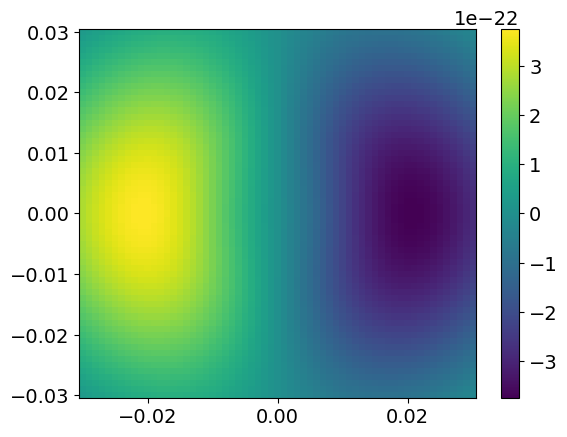

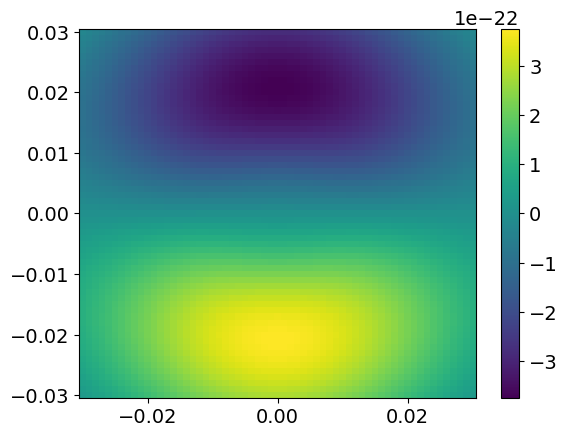

In [33]:
force_quadrupole = eql_quadrupole.force(0, X, Y, np.zeros(X.shape))

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[0])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[1])
cbar = fig.colorbar(cax)

C:\Users\ogras\AppData\Local\Temp\ipykernel_50316\3089133271.py:72: RuntimeWarning: divide by zero encountered in divide
  electric_field_inverse = np.nan_to_num(1 / electric_field)


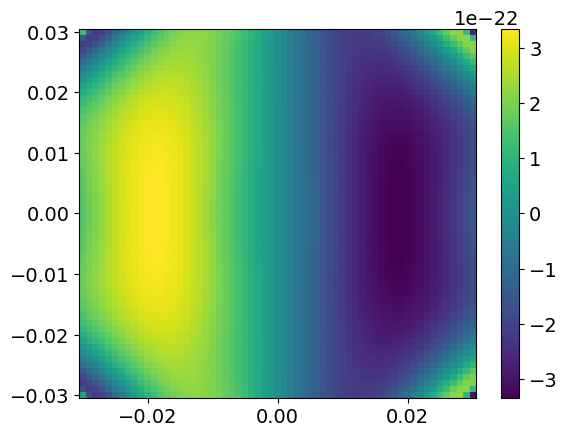

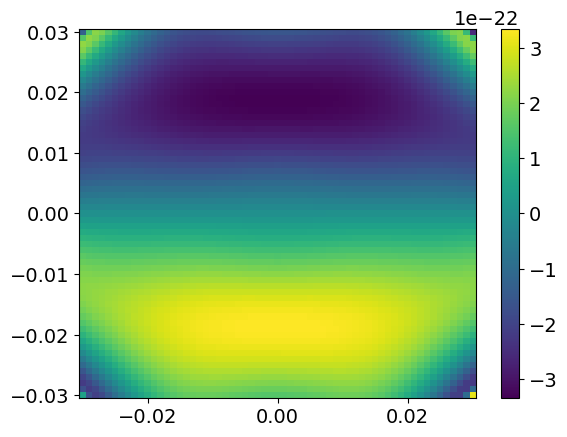

In [34]:
force_quadrupole = eql_comsol.force(0, X, Y, np.zeros(X.shape))

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[0])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[1])
cbar = fig.colorbar(cax)

In [35]:
sections_poly = [fourK, fourtyK, bbexit, rc, spa, eql_quadrupole, det]
section_data_poly, trajectories_poly = propagate_trajectories(
    sections_poly,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)

In [36]:
print(
    f"{section_data_poly[-1].throughput / section_data[-1].throughput * 100:.2f}% w.r.t. quadrupole potential"
)

100.00% w.r.t. quadrupole potential


In [37]:
xs, ys = smp.symbols("x,y")
Vs = smp.Function("V")(xs, ys)

Es = smp.sqrt(smp.diff(Vs, xs) ** 2 + smp.diff(Vs, ys) ** 2)

display((smp.diff(Es, xs)))
display((smp.diff(Es, ys)))

(Derivative(V(x, y), x)*Derivative(V(x, y), (x, 2)) + Derivative(V(x, y), y)*Derivative(V(x, y), x, y))/sqrt(Derivative(V(x, y), x)**2 + Derivative(V(x, y), y)**2)

(Derivative(V(x, y), x)*Derivative(V(x, y), x, y) + Derivative(V(x, y), y)*Derivative(V(x, y), (y, 2)))/sqrt(Derivative(V(x, y), x)**2 + Derivative(V(x, y), y)**2)

# Potential for centrex-trajectories

In [ ]:
mask_fit = np.sqrt(x**2 + y**2) < lens_radius
v_fit = v.copy()
v_fit[~mask_fit] = np.nan
v_fit

kx, ky = 6, 6
potential_trajectories = Polynomial2D(kx, ky)
sol = potential_trajectories.fit(
    x, y, v_fit / lens_potential, zero_terms=[(0, 0), (1, 0), (0, 1)]
)
potential_trajectories.coeffs

array([[ 0.00000000e+00,  0.00000000e+00, -1.85807316e-03,
        -3.68838654e-01,  9.05179603e+01,  5.02802652e+02,
        -2.33774653e+05],
       [ 0.00000000e+00, -4.01516882e+03, -4.57787118e-02,
        -8.53726662e+03, -9.44499189e+03,  5.34213172e+08,
         2.04894221e+07],
       [ 1.55556469e-02, -1.08269983e+01,  4.98195718e+02,
         1.21401040e+05, -6.62042908e+06, -2.00043668e+08,
         1.63384388e+10],
       [ 4.95047018e-01, -8.94339785e+03,  1.44796476e+04,
        -1.69855041e+09, -6.86084354e+07, -6.47064425e+09,
        -2.57901217e+04],
       [-1.83341406e+02,  4.73566410e+04,  2.21617329e+06,
        -3.02270553e+08, -7.46259863e+09, -1.14022371e+05,
        -3.74750620e+05],
       [-1.83757741e+03,  5.34389645e+08, -1.65987718e+07,
         6.46968544e+09, -2.13239592e+04, -1.31548209e+02,
        -7.07835673e+00],
       [ 2.78503072e+05, -4.15374780e+07, -1.08606156e+09,
        -1.22530620e+05, -2.91966193e+06, -3.60532824e+01,
        -5.5171672

In [45]:
%%timeit
potential_trajectories.evaluate(0.0, 0.0)

21.3 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
%%timeit
potential_trajectories.fast_scalar_evaluate(0.0, 0.0)

612 ns ± 33.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


# Potential along z
Lens potential drop at edges of the lens

In [ ]:
def tanh_rise(x, center=-0.25, rise_width=0.05):
    """
    A tanh‐shaped step that goes from –1 to +1 over approximately `rise_width`,
    with its inflection point at `center`.

    Parameters
    ----------
    x : array-like
        Input coordinate(s).
    center : float
        The x-value at which tanh = 0 (midpoint of the rise).
    rise_width : float
        Approximate width of the transition from –1/ to +1.

    Returns
    -------
    y : ndarray
        tanh((x – center) / (rise_width/2))
    """
    # scale so that ±(rise_width/2) in x corresponds to about ±1 in the tanh argument
    scale = rise_width / 2.0
    return (np.tanh((x - center) / scale) + 1) / 2

In [12]:
half_radius = np.unique(potential_xy[:, 0])[
    np.argmin(abs(np.unique(potential_xy[:, 0]) - lens_radius / 2))
]
mask = (potential_xy[:, 0] == -half_radius) & (potential_xy[:, 1] == -half_radius)

z = potential_xy[mask, 2].copy()
indices_sorted = np.argsort(z)
z = z[indices_sorted]
pot = potential_xy[mask, 3].copy()[indices_sorted]

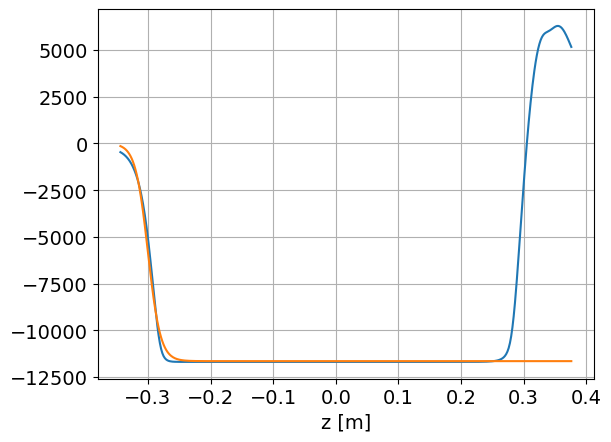

In [14]:
fig, ax = plt.subplots()
ax.plot(z - z_center, pot)
ax.plot(z - z_center, -11_650 * tanh_rise(z - z_center, center=-0.3, rise_width=0.04))
ax.set_xlabel("z [m]")
ax.grid()

In [ ]:
from scipy.special import erf


def erf_step(z, y0, Δy, zc, σ):
    return y0 + 0.5 * Δy * (1 + erf((z - zc) / (np.sqrt(2) * σ)))


def logistic(z, y0, Δy, zc, k):
    return y0 + Δy / (1 + np.exp(-(z - zc) / k))


def richards(z, y0, Δy, zc, Q, B, ν):
    return y0 + Δy / ((1 + Q * np.exp(-B * (z - zc))) ** (1 / ν))

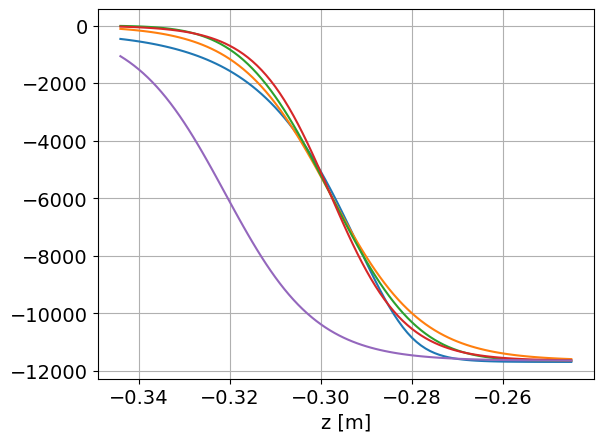

In [ ]:
sl = np.s_[:100]
fig, ax = plt.subplots()
ax.plot(z[sl] - z_center, pot[sl])
ax.plot(
    z[sl] - z_center,
    -11_650 * tanh_rise(z[sl] - z_center, center=-0.298, rise_width=0.04),
)
ax.plot(z[sl] - z_center, -erf_step(z[sl] - z_center, 0, 11_650, -0.298, 0.015))
ax.plot(z[sl] - z_center, -logistic(z[sl] - z_center, 0, 11_650, -0.298, 0.008))
ax.plot(z[sl] - z_center, -richards(z[sl] - z_center, 0, 11_650, -0.298, 0.1, 100, 1))
ax.set_xlabel("z [m]")
ax.grid()

In [25]:
def richards(
    z: NDArray_or_Float,
    zc: float,
    y0: float,
    Δy: float,
    Q: float,
    B: float,
    ν: float,
) -> NDArray_or_Float:
    """Compute the Richards (generalized logistic) growth curve.

    The Richards function is a flexible S-shaped curve that can model asymmetric transitions.

    Args:
        z (NDArray_or_Float): Independent variable (e.g., position or time).
        y0 (float): Lower asymptote (minimum plateau) of the curve.
        Δy (float): Total rise (difference between upper and lower plateau).
        Q (float): Horizontal shift parameter affecting the curve’s midpoint.
        B (float): Growth rate parameter controlling steepness.
        zc (float): Midpoint (inflection point) of the transition.
        ν (float): Shape parameter controlling the asymmetry of the two tails.

    Returns:
        NDArray_or_Float: The Richards-curve value(s) at `z`.
    """
    return y0 + Δy / ((1 + Q * np.exp(-B * (z - zc))) ** (1 / ν))

In [32]:
from scipy.optimize import curve_fit

mask = (potential_xy[:, 0] == -half_radius) & (potential_xy[:, 1] == -half_radius)

z = potential_xy[mask, 2].copy()
indices_sorted = np.argsort(z)
z = z[indices_sorted]
pot = potential_xy[mask, 3].copy()[indices_sorted]

sl = np.s_[:100]
popt, pcov = curve_fit(
    richards,
    z[sl] - z_center,
    pot[sl],
    p0=(-0.298, 0, np.abs(pot[sl]).max() * np.sign(pot[sl].mean()), 0.1, 100, 1),
)


C:\Users\Olivier\AppData\Local\Temp\ipykernel_52952\4025924869.py:26: RuntimeWarning: overflow encountered in exp
  return y0 + Δy / ((1 + Q * np.exp(-B * (z - zc))) ** (1 / ν))
C:\Users\Olivier\AppData\Local\Temp\ipykernel_52952\4025924869.py:26: RuntimeWarning: divide by zero encountered in divide
  return y0 + Δy / ((1 + Q * np.exp(-B * (z - zc))) ** (1 / ν))


In [48]:
import numpy as np
from numpy.typing import NDArray
from typing import Union, Sequence


def double_richards_symmetric(
    z: Union[float, NDArray[np.float64]],
    c1: float,
    c2: float,
    y0: float,
    dy: float,
    Q: float,
    B: float,
    nu: float,
) -> Union[float, NDArray[np.float64]]:
    """
    Compute a symmetric double-inflection Richards curve.

    This function generates two generalized logistic (Richards) transitions of
    equal shape and amplitude `dy`, one upward at `centers[0]` and one downward
    at `centers[1]`, producing a flat plateau of height `y0 + dy` between them
    and returning to `y0` outside the transition regions.

    Args:
        z (float or NDArray[np.float64]]): Independent variable(s).
        c1 (float): Center of the rising transition.
        c2 (float): Center of the falling transition.
        y0 (float): Baseline value before rise and after fall.
        dy (float): Amplitude of both the rising and falling segments.
        Q (float): Horizontal-shift parameter (same for both transitions).
        B (float): Growth-rate/steepness parameter (same for both).
        nu (float): Shape/asymmetry parameter (same for both).

    Returns:
        float or NDArray[np.float64]]: Curve values at `z`, rising then falling.
    """
    z_arr = np.asarray(z)
    # rising transition
    r1 = 1.0 / ((1.0 + Q * np.exp(-B * (z_arr - c1))) ** (1.0 / nu))
    # mirrored falling transition
    r2 = 1.0 / ((1.0 + Q * np.exp(-B * (c2 - z_arr))) ** (1.0 / nu))
    # combine with plateau in between
    return y0 + dy * (r1 + r2 - 1.0)

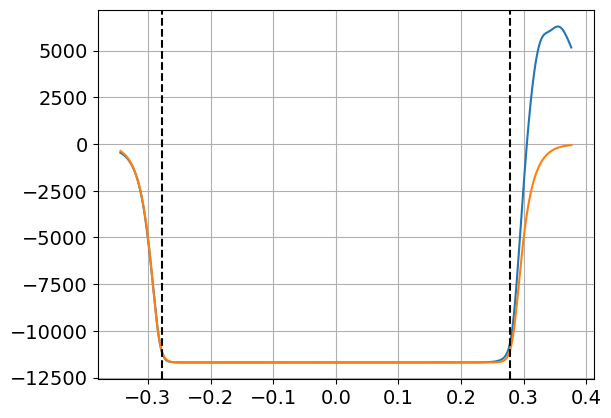

In [49]:
mask = (potential_xy[:, 0] == -half_radius) & (potential_xy[:, 1] == -half_radius)

z = potential_xy[mask, 2].copy()
indices_sorted = np.argsort(z)
z = z[indices_sorted]
pot = potential_xy[mask, 3].copy()[indices_sorted]

args = list(popt)
args[1] = 0.0
args[2] = 1.0
args.insert(1, -args[0])

popt
sl = np.s_[:1000]
fig, ax = plt.subplots()
ax.plot(z[sl] - z_center, pot[sl])
ax.plot(
    z[sl] - z_center,
    pot[sl][200] * double_richards_symmetric(z[sl] - z_center, *args),
)
ax.axvline(popt[0], color="black", linestyle="--")
ax.axvline(-popt[0], color="black", linestyle="--")
ax.grid()


In [45]:
print(f"turning point = {popt[0]:.3f}")

turning point = -0.278
